# Cyclocross results trends 2023-2024 season

In [220]:
# Standard libraries
import hashlib
import importlib
from io import StringIO
import os

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models and preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# External tools/utilities
from faker import Faker
from data_cleaning import join_all

### Initialize lists for data import and cleaning

In [221]:


events = ['Barnburner at Steilacoom 2023.txt', 'Starcrossed at Marymoor 2023.txt', 'Beach Party At Silver Lake 2023.txt',
'Magnuson Park Cross 2023.txt', 'North 40 at LeMay 2023.txt', 'Woodland Park GP 2023.txt', 'The Beach Party at Silver Lake 2024.txt',
'Starcrossed at Marymoor 2024.txt', 'Barnburner at Steilacoom 2024.txt', 'Magnuson Park Cross 2024.txt', 'North 40 - LeMay 2024.txt',
'Woodland Park Gran Prix 2024.txt']
dates = ['2023-09-10', '2023-09-23', '2023-10-08', '2023-10-22', '2023-11-05', '2023-11-19', '2024-09-08', '2024-09-21', '2024-10-06', '2024-10-20', '2024-11-03', '2024-11-17']


### Clean and join disparate race datasets

In [222]:
df = join_all(events, dates)

Initializing main data frame based on: Barnburner at Steilacoom 2023.txt
Appending: Barnburner at Steilacoom 2023.txt
Appending: Starcrossed at Marymoor 2023.txt
Appending: Beach Party At Silver Lake 2023.txt
Appending: Magnuson Park Cross 2023.txt
Appending: North 40 at LeMay 2023.txt
Appending: Woodland Park GP 2023.txt
Appending: The Beach Party at Silver Lake 2024.txt
Appending: Starcrossed at Marymoor 2024.txt
Appending: Barnburner at Steilacoom 2024.txt
Appending: Magnuson Park Cross 2024.txt
Appending: North 40 - LeMay 2024.txt
Appending: Woodland Park Gran Prix 2024.txt


### Anonymize data for analysis while maintaining meaningful relationships

In [223]:
fake = Faker()

# 1. Drop unwanted columns
cols_to_drop = [col for col in df.columns if (
    col.lower().startswith("lap") or
    col.lower() in [
        "laps", "difference", "% back", "% winning", "% average", "% median", 'team_name'
    ]
)]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Consistent hash for racer ID
def hash_name(name):
    if pd.isnull(name):
        return 'unknown'
    return hashlib.sha256(str(name).encode()).hexdigest()[:10]

df['racer_id'] = df['name'].apply(hash_name)

# 3. Anonymize category
unique_categories = df['category'].unique()
category_map = {cat: fake.word().capitalize() for cat in unique_categories}
df['anon_category'] = df['category'].map(category_map)

# 4. Anonymize age (±3 years)
df['anon_age'] = df['age'] + np.random.randint(-3, 4, size=len(df))

# 5. Perturb time within each race category-date group
def perturb_group(group):
    # Ensure numeric types
    group['average_lap_time'] = pd.to_numeric(group['average_lap_time'], errors='coerce')
    group['place'] = pd.to_numeric(group['place'], errors='coerce')

    noise = np.random.uniform(-3, 3, size=len(group))  # seconds
    group['anon_time'] = group['average_lap_time'] + noise

    n = len(group)
    place_noise = np.random.randint(-2, 3, size=n)
    group['anon_place'] = (group['place'] + place_noise).clip(lower=1, upper=n)

    return group

df = df.groupby(['category', 'date']).apply(perturb_group).reset_index(drop=True)

# 6. Drop original PII and sensitive fields
df = df.drop(columns=['name', 'category', 'average_lap_time', 'age', 'place', 'time', 'bib', 'team_points', 'first name', 'last name', 'team name'])

# Save result
df.to_csv("data/anonymized_data.csv", index=False)

C:\Users\kbcor_mas\AppData\Local\Temp\ipykernel_50436\4242767337.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['category', 'date']).apply(perturb_group).reset_index(drop=True)


### Total number of races raced by gender identity

In [224]:
df['gender'] = df['gender'].replace(to_replace=['Non-Binary', 'Non-binary'], value='Nonbinary')
df['gender'].value_counts()

gender
Male         5925
Female       1603
Nonbinary     120
Name: count, dtype: int64

about 3.7 as much adult male as adult female participation (num individual races per gender)

## Exploratory Data Analysis

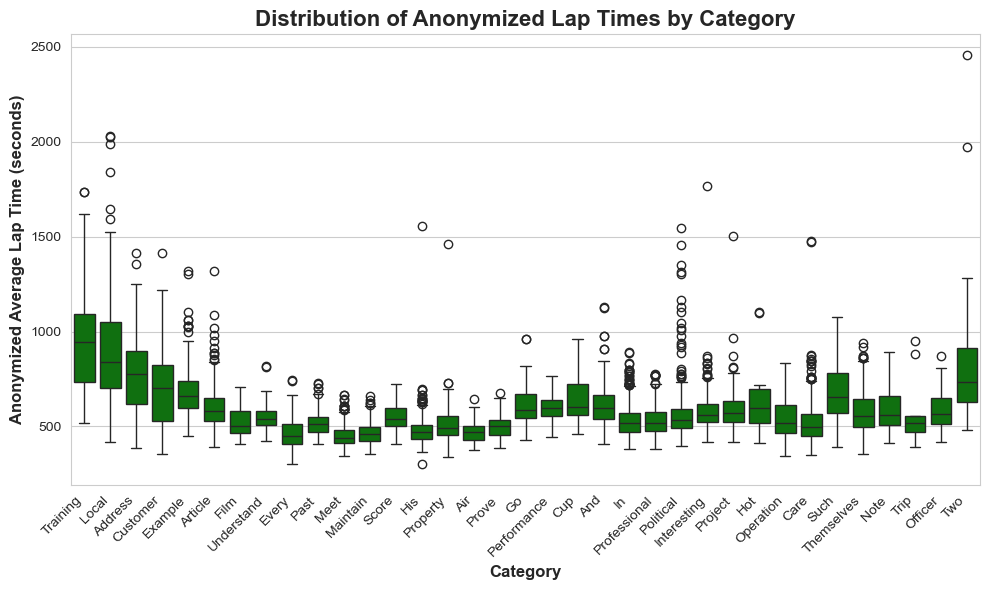

In [225]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Ensure the 'plots' directory exists
os.makedirs("plots", exist_ok=True)

# Use a green color palette for boxes
sns.boxplot(data=df, x='anon_category', y='anon_time', color='green')

# Bold and styled labels
plt.title('Distribution of Anonymized Lap Times by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Anonymized Average Lap Time (seconds)', fontsize=12, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.savefig("plots/lap_times_by_category.png", dpi=300)

plt.show()

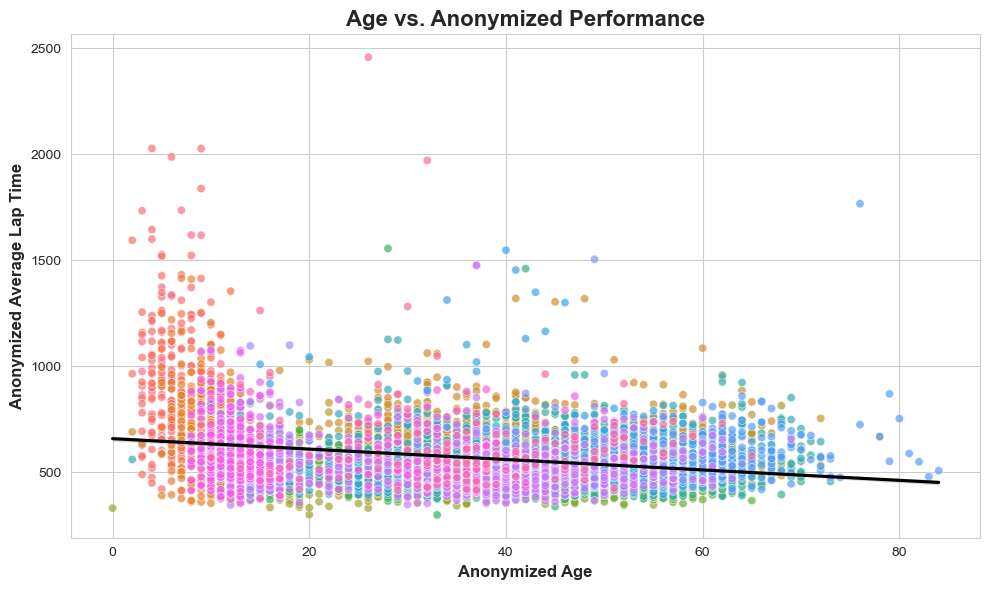

In [226]:
plt.figure(figsize=(10, 6))

# plot style
sns.set_style("whitegrid")

# Ensure the 'plots' directory exists
os.makedirs("plots", exist_ok=True)

# scatter points with category hue
sns.scatterplot(data=df, x='anon_age', y='anon_time', hue='anon_category', alpha=0.7, marker='o', edgecolor='white', legend=None)

# regression trend line
sns.regplot(data=df, x='anon_age', y='anon_time', scatter=False, color='black', label='Overall Trend')

# Title and labels with bold font
plt.title('Age vs. Anonymized Performance', fontsize=16, fontweight='bold')
plt.xlabel('Anonymized Age', fontsize=12, fontweight='bold')
plt.ylabel('Anonymized Average Lap Time', fontsize=12, fontweight='bold')

# layout
plt.tight_layout()

plt.savefig("plots/age_vs_performance.png", dpi=300)

plt.show()

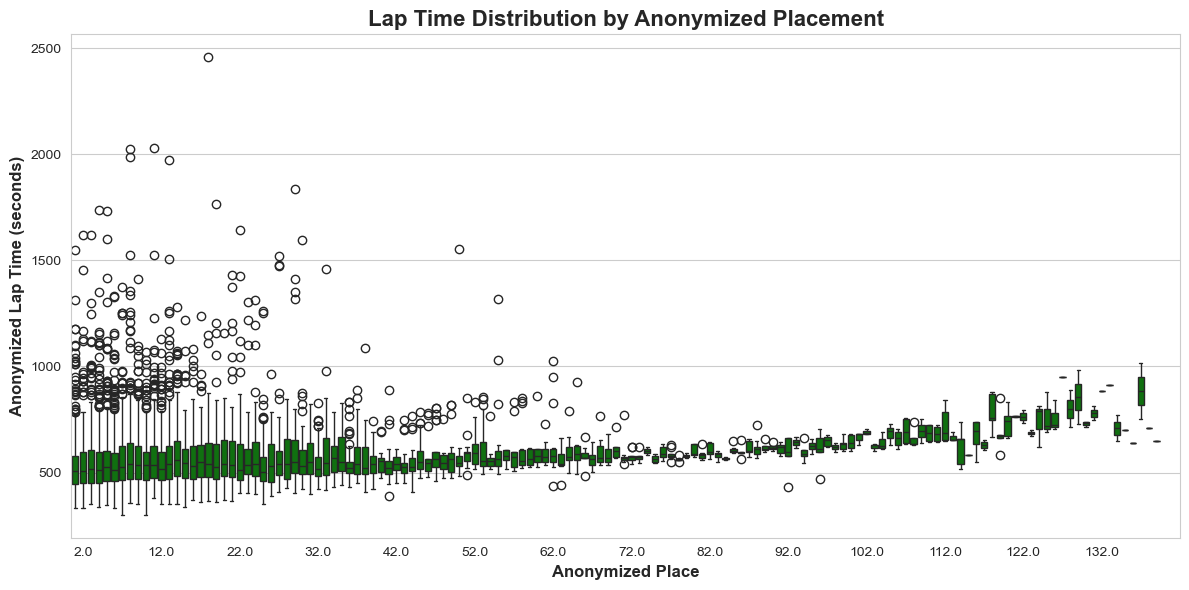

In [227]:

# Set style for clarity and consistency
sns.set_style("whitegrid")

# Ensure the 'plots' directory exists
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(12, 6))

# Green boxplot
sns.boxplot(data=df, x='anon_place', y='anon_time', color='green')

# Bold, readable titles and labels
plt.title('Lap Time Distribution by Anonymized Placement', fontsize=16, fontweight='bold')
plt.xlabel('Anonymized Place', fontsize=12, fontweight='bold')
plt.ylabel('Anonymized Lap Time (seconds)', fontsize=12, fontweight='bold')

# Show x-axis ticks every 10 places
max_place = df['anon_place'].max()
plt.xticks(ticks=range(1, int(max_place) + 1, 10))

plt.tight_layout()

plt.savefig("plots/lap_time_distribution_placement.png", dpi=300)

plt.show()

C:\Users\kbcor_mas\AppData\Local\Temp\ipykernel_50436\3784441823.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


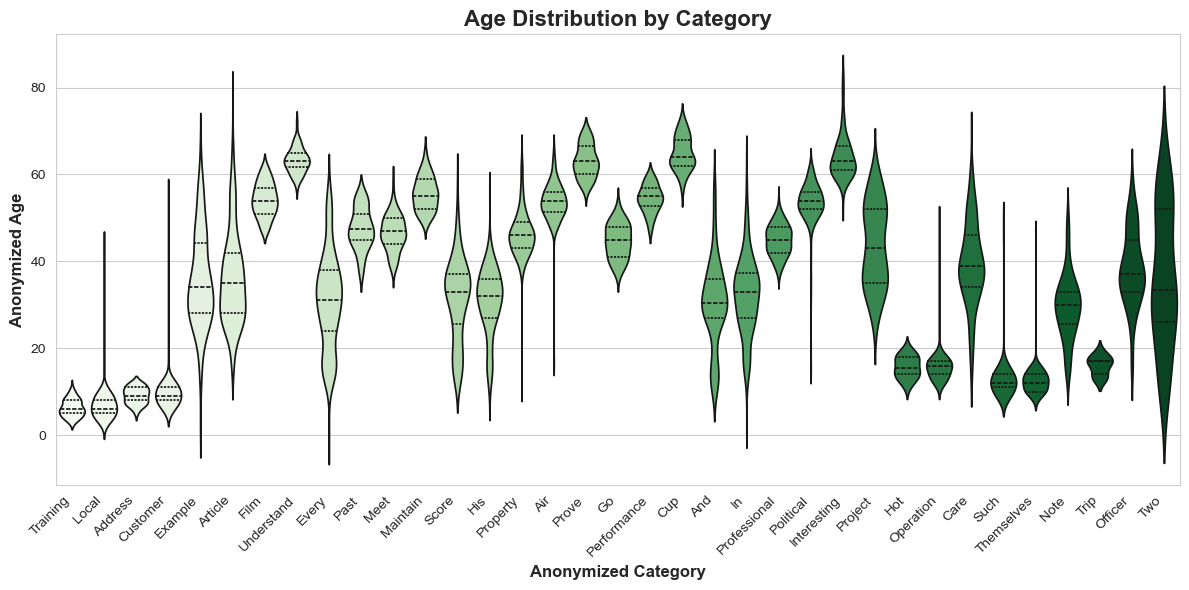

In [228]:
# Apply a clean grid background
sns.set_style("whitegrid")

# Ensure the 'plots' directory exists
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(12, 6))

# Green violin plot with quartile markers
sns.violinplot(
    data=df,
    x='anon_category',
    y='anon_age',
    inner='quartile',
    palette='Greens'
)

# Bold axis labels and title
plt.title('Age Distribution by Category', fontsize=16, fontweight='bold')
plt.xlabel('Anonymized Category', fontsize=12, fontweight='bold')
plt.ylabel('Anonymized Age', fontsize=12, fontweight='bold')

# Rotate category names for clarity
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.savefig("plots/age_distribution_by_category.png", dpi=300)

plt.show()

In [229]:
def top_gap(group):
    first = group.loc[group['anon_place'] == 1, 'anon_time'].min()
    fifth = group.loc[group['anon_place'] == 5, 'anon_time'].min()
    return pd.Series({'time_gap_1st_to_5th': fifth - first})

gap_df = df.groupby('anon_category').apply(top_gap).dropna()
print(gap_df.sort_values('time_gap_1st_to_5th'))

               time_gap_1st_to_5th
anon_category                     
In                      -32.982133
Professional            -20.396078
Local                   -15.716629
Project                  -5.406318
Prove                     3.246688
Customer                  7.478118
His                       8.893367
Film                      9.652919
Air                      10.951521
Political                11.865476
Every                    12.115151
Meet                     12.303273
Article                  14.876923
Operation                22.700672
Officer                  25.917525
Past                     35.552242
And                      38.136383
Themselves               41.507618
Score                    43.889980
Property                 46.509482
Care                     46.556576
Interesting              47.773828
Go                       49.190666
Maintain                 52.588657
Cup                      54.103035
Understand               68.532060
Note                

C:\Users\kbcor_mas\AppData\Local\Temp\ipykernel_50436\1499151989.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gap_df = df.groupby('anon_category').apply(top_gap).dropna()


## Anomaly detection

### Showing decision boundaries for anomaly detection

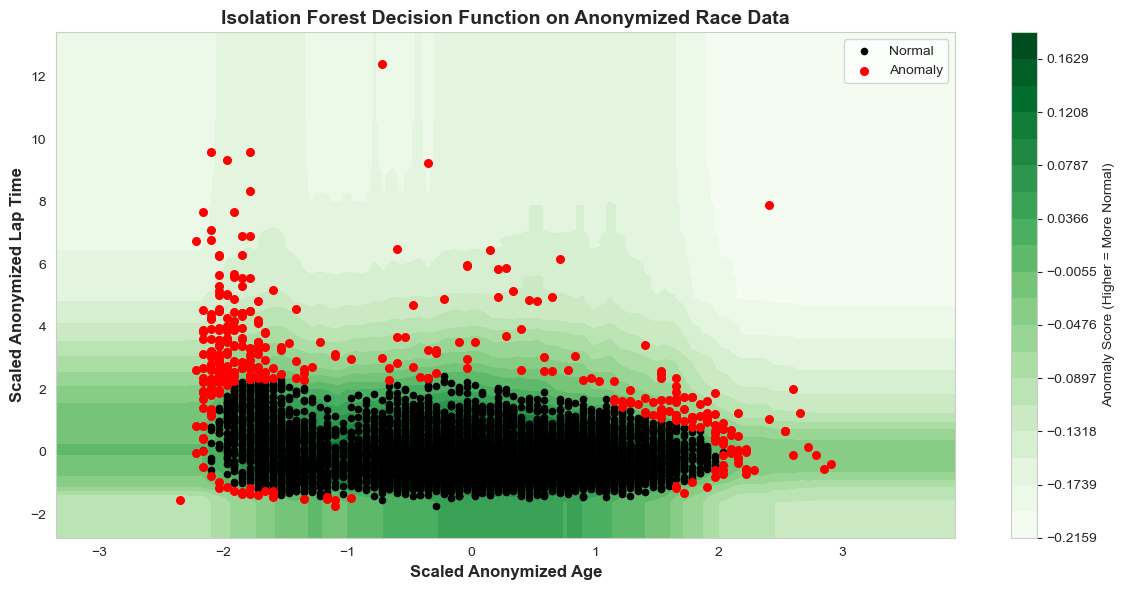

In [230]:
# --- 1. Load and scale your data ---
features = ['anon_age', 'anon_time']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Fit Isolation Forest ---
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)
pred = iso_forest.predict(X_scaled)
scores = iso_forest.decision_function(X_scaled)

# --- 3. Meshgrid for decision surface ---
xx, yy = np.meshgrid(
    np.linspace(X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1, 100),
    np.linspace(X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1, 100)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = iso_forest.decision_function(grid)
Z = Z.reshape(xx.shape)

# --- 4. Plot ---
plt.figure(figsize=(12, 6))
plt.contourf(xx, yy, Z, cmap='Greens', levels=np.linspace(Z.min(), Z.max(), 20))
plt.colorbar(label='Anomaly Score (Higher = More Normal)')

# Overlay points
normal = X_scaled[pred == 1]
anomalies = X_scaled[pred == -1]
plt.scatter(normal[:, 0], normal[:, 1], c='black', s=20, label='Normal')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', s=30, label='Anomaly')

# Labels and title
plt.title("Isolation Forest Decision Function on Anonymized Race Data", fontsize=14, fontweight='bold')
plt.xlabel("Scaled Anonymized Age", fontsize=12, fontweight='bold')
plt.ylabel("Scaled Anonymized Lap Time", fontsize=12, fontweight='bold')
plt.legend()
plt.tight_layout()

# --- Save plot ---
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/isolation_forest_decision_surface.png", dpi=300)

# Show plot
plt.show()

### Selecting only anomalously fast participants relative to category

Z-score fast anomalies: 0
Isolation Forest fast anomalies: 142
Combined fast outliers: 142


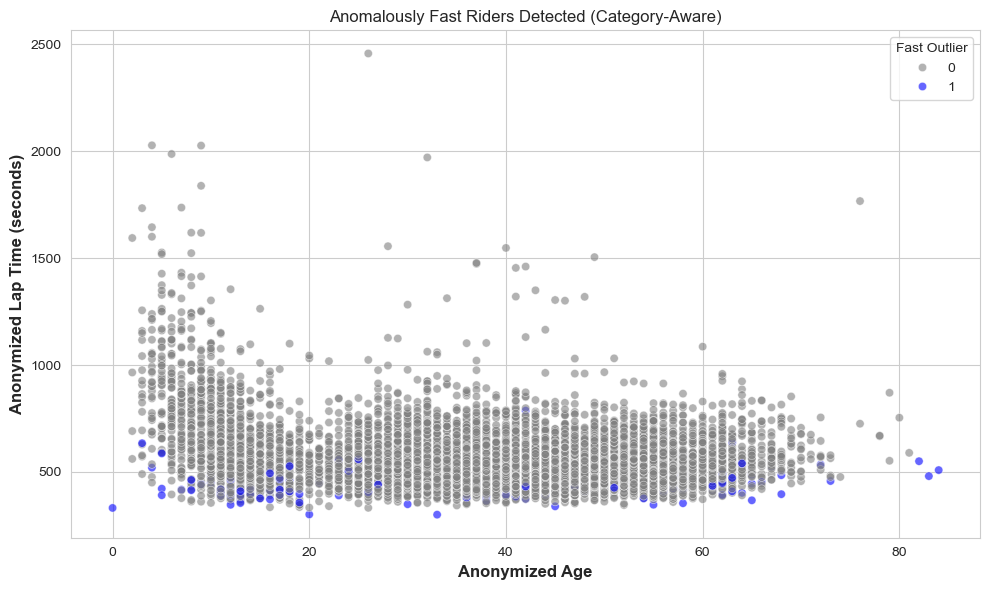

In [231]:
# --- 1. Z-Score Detection for Fast Only (by category) ---
def detect_fast_zscore_anomalies(df, threshold=3):
    df['z_fast'] = False
    df['z_score'] = np.nan

    for cat in df['anon_category'].dropna().unique():
        group = df['anon_category'] == cat
        z_scores = (df.loc[group, 'anon_time'] - df.loc[group, 'anon_time'].mean()) / df.loc[group, 'anon_time'].std()
        df.loc[group, 'z_score'] = z_scores
        df.loc[group, 'z_fast'] = z_scores < -threshold

    return df

# --- 2. Isolation Forest Outliers (by category, filter for fast) ---
def detect_fast_isolation_forest_anomalies(df, features=['anon_time', 'anon_age'], contamination=0.05):
    df['iforest_fast'] = False
    df['iforest_raw'] = np.nan

    for cat in df['anon_category'].dropna().unique():
        subset = df[df['anon_category'] == cat].copy()
        if len(subset) < 7:
            continue  # skip small groups

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(subset[features])

        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        preds = iso_forest.fit_predict(X_scaled)

        median_time = subset['anon_time'].median()
        fast_mask = (preds == -1) & (subset['anon_time'] < median_time)

        df.loc[subset.index, 'iforest_raw'] = preds
        df.loc[subset.index, 'iforest_fast'] = fast_mask

    return df

# --- Run Detection ---
df = detect_fast_zscore_anomalies(df)
df = detect_fast_isolation_forest_anomalies(df)

# --- Combine Anomaly Flags into Final Integer Column ---
df['fast_outliers'] = ((df['z_fast'] | df['iforest_fast'])).astype(int)

# --- Output Summary ---
print("Z-score fast anomalies:", df['z_fast'].sum())
print("Isolation Forest fast anomalies:", df['iforest_fast'].sum())
print("Combined fast outliers:", df['fast_outliers'].sum())

# --- Ensure plot directory exists ---
os.makedirs("plots", exist_ok=True)

# --- Visualize Fast Anomalies ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='anon_age',
    y='anon_time',
    hue='fast_outliers',
    palette={1: 'blue', 0: 'gray'},
    alpha=0.6
)
plt.title('Anomalously Fast Riders Detected (Category-Aware)')
plt.xlabel('Anonymized Age', fontsize=12, fontweight='bold')
plt.ylabel('Anonymized Lap Time (seconds)', fontsize=12, fontweight='bold')
plt.legend(title='Fast Outlier')
plt.tight_layout()

# Save plot
plt.savefig("plots/fast_outlier_scatter.png", dpi=300)

# Save plot
plt.savefig("plots/fast_outlier_scatter.png", dpi=300)

# --- Optional: Save Fast Anomalies ---
fast_only = df[df['fast_outliers'] == 1]
fast_only.to_csv('data/fast_anomalies_only.csv', index=False)

### 📊 Example Output Interpretation:
#### relative_time_to_peer = 0.92 means the racer is 8% faster than peers

#### MAE of 0.05 = avg prediction is off by ~5%

In [232]:
# --- Helper: define age buckets ---
def get_age_group(age):
    return f"{int(age // 5) * 5}-{int(age // 5) * 5 + 4}"

# --- Step 1: Preprocessing ---
df = df.dropna(subset=["anon_time", "anon_age", "gender", "anon_category", "racer_id", "date"])
df["age_group"] = df["anon_age"].apply(get_age_group)
df["peer_key"] = df["age_group"] + "_" + df["gender"]
df = df.sort_values(by=["racer_id", "date"])

# --- Step 2: Compute peer average for each row based on current race demographics ---
peer_avg_lookup = df.groupby("peer_key")["anon_time"].mean().to_dict()
df["peer_mean_time"] = df["peer_key"].map(peer_avg_lookup)
df = df.dropna(subset=["peer_mean_time"])
df["relative_time_to_peer"] = df["anon_time"] / df["peer_mean_time"]

# --- Step 3: Compute historical average relative time for each racer before each race ---
historical_means = []
df["race_index"] = df.groupby("racer_id").cumcount()

for idx, row in df.iterrows():
    past_races = df[
        (df["racer_id"] == row["racer_id"]) &
        (df["date"] < row["date"])
    ]
    if len(past_races) >= 1:
        hist_mean = past_races["relative_time_to_peer"].mean()
    else:
        hist_mean = np.nan
    historical_means.append(hist_mean)

df["historical_relative_mean"] = historical_means
df = df.dropna(subset=["historical_relative_mean"])

# --- Step 4: Feature engineering ---
df["anon_category_encoded"] = LabelEncoder().fit_transform(df["anon_category"])
df["anon_category"] = df["anon_category_encoded"]

features = ["anon_age", "anon_place", "anon_category", "historical_relative_mean"]
target = "relative_time_to_peer"

# --- Step 5: Train/test split ---
train_data = df[df["fast_outliers"] == 0]
test_data = df[df["fast_outliers"] == 1].copy()

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# --- Step 6: Train model and predict ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
test_data["predicted_relative_time_to_peer"] = model.predict(X_test)

# --- Step 7: Evaluation ---
actual = y_test
predicted = test_data["predicted_relative_time_to_peer"]

mae = mean_absolute_error(actual, predicted)
rmse = mean_squared_error(actual, predicted)

print("\nPerformance on Fast Outliers (historical-based prediction):")
print(f"MAE: {mae:.4f} (~{mae*100:.1f}% deviation)")
print(f"RMSE: {rmse:.4f}")

# --- Optional: Save predictions ---
cols_to_save = ["relative_time_to_peer", "predicted_relative_time_to_peer", "historical_relative_mean"]
if "racer_id" in test_data.columns:
    cols_to_save.insert(0, "racer_id")

test_data[cols_to_save].to_csv("data/fast_outlier_predictions_historical.csv", index=False)


Performance on Fast Outliers (historical-based prediction):
MAE: 0.1796 (~18.0% deviation)
RMSE: 0.0453


In [233]:
# Ensure necessary columns are present
actual = test_data["relative_time_to_peer"]
predicted = test_data["predicted_relative_time_to_peer"]
errors = predicted - actual


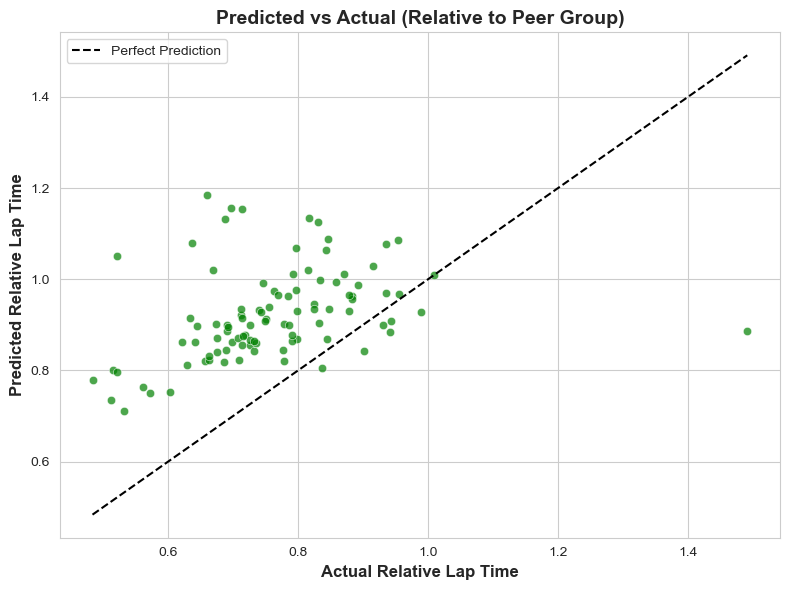

In [234]:
# --- 1. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.7, color='green')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], '--', color='black', label='Perfect Prediction')
plt.xlabel("Actual Relative Lap Time", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Relative Lap Time", fontsize=12, fontweight='bold')
plt.title("Predicted vs Actual (Relative to Peer Group)", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("plots/predicted_vs_actual_relative.png", dpi=300)
plt.show()

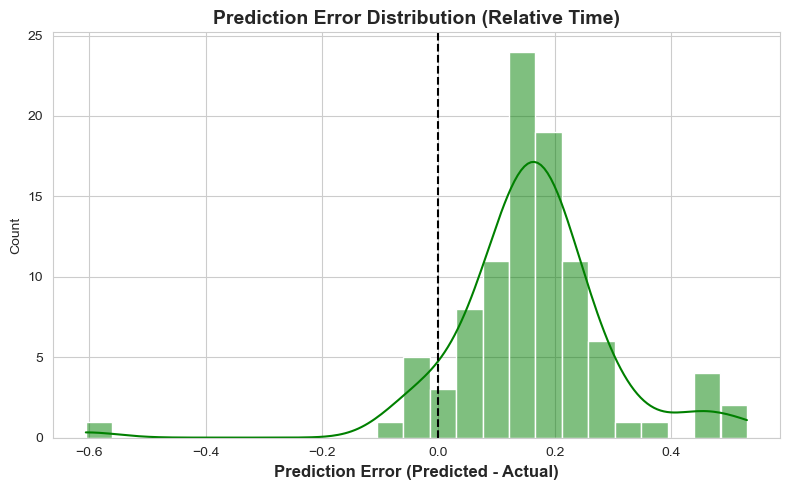

In [235]:
# --- 2. Prediction Error Histogram ---
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=25, kde=True, color='green')
plt.axvline(0, color='black', linestyle='--')
plt.title("Prediction Error Distribution (Relative Time)", fontsize=14, fontweight='bold')
plt.xlabel("Prediction Error (Predicted - Actual)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("plots/prediction_error_distribution.png", dpi=300)
plt.show()

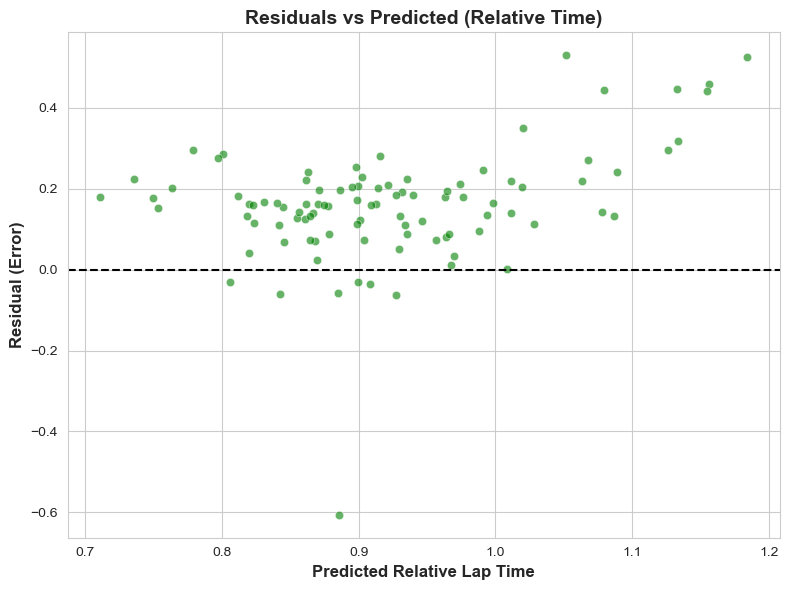

In [236]:
# --- 3. Residuals vs Predicted ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predicted, y=errors, color='green', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals vs Predicted (Relative Time)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Relative Lap Time", fontsize=12, fontweight='bold')
plt.ylabel("Residual (Error)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("plots/residuals_vs_predicted.png", dpi=300)
plt.show()

In [237]:
# --- Define age group ---
def get_age_group(age):
    return f"{int(age // 5) * 5}-{int(age // 5) * 5 + 4}"

# --- Preprocessing ---
df = df.dropna(subset=["anon_time", "anon_age", "gender", "anon_category", "racer_id", "date"])
df["age_group"] = df["anon_age"].apply(get_age_group)
df["peer_key"] = df["age_group"] + "_" + df["gender"]
df = df.sort_values(by=["racer_id", "date"])

# --- Compute peer mean lap times ---
peer_avg = df.groupby("peer_key")["anon_time"].mean().to_dict()
df["peer_mean_time"] = df["peer_key"].map(peer_avg)
df = df.dropna(subset=["peer_mean_time"])

# --- Compute relative time to peer mean ---
df["relative_time_to_peer"] = df["anon_time"] / df["peer_mean_time"]

# --- Compute historical average relative time per racer before each race ---
historical_means = []
df["race_index"] = df.groupby("racer_id").cumcount()

for idx, row in df.iterrows():
    past_races = df[
        (df["racer_id"] == row["racer_id"]) &
        (df["date"] < row["date"])
    ]
    if len(past_races) >= 1:
        hist_mean = past_races["relative_time_to_peer"].mean()
    else:
        hist_mean = np.nan
    historical_means.append(hist_mean)

df["historical_relative_mean"] = historical_means
df = df.dropna(subset=["historical_relative_mean"])

# --- Encode categorical data ---
df["anon_category_encoded"] = LabelEncoder().fit_transform(df["anon_category"])
df["anon_category"] = df["anon_category_encoded"]

# --- Define features and target ---
features = ["anon_age", "anon_place", "anon_category", "historical_relative_mean"]
target = "relative_time_to_peer"

X = df[features]
y = df[target]

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predict on full dataset ---
df["predicted_relative_time_to_peer"] = model.predict(X)

# --- Evaluate on test set ---
y_test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred)

print("\nPerformance on All Racers (historical-based):")
print(f"MAE: {mae:.4f} (~{mae*100:.1f}% avg error)")
print(f"RMSE: {rmse:.4f}")

# --- Save results ---
cols_to_save = ["anon_time", "peer_mean_time", "relative_time_to_peer", "historical_relative_mean", "predicted_relative_time_to_peer"]
if "racer_id" in df.columns:
    cols_to_save.insert(0, "racer_id")

df[cols_to_save].to_csv("data/all_predictions_historical_relative.csv", index=False)


Performance on All Racers (historical-based):
MAE: 0.0988 (~9.9% avg error)
RMSE: 0.0199


In [238]:

# --- Prepare data for visualization ---
actual = df["relative_time_to_peer"]
predicted = df["predicted_relative_time_to_peer"]
errors = predicted - actual

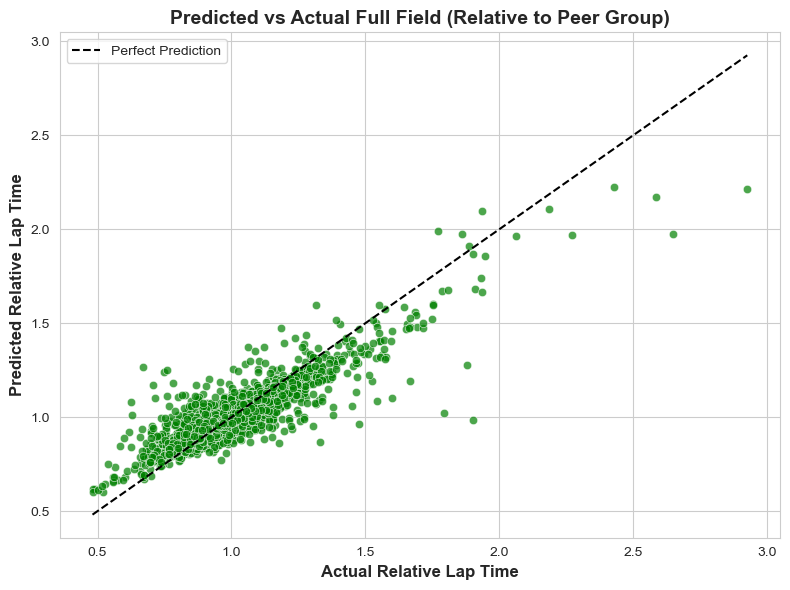

In [239]:
# --- 1. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.7, color='green')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], '--', color='black', label='Perfect Prediction')
plt.xlabel("Actual Relative Lap Time", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Relative Lap Time", fontsize=12, fontweight='bold')
plt.title("Predicted vs Actual Full Field (Relative to Peer Group)", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("plots/predicted_vs_actual_relative_full.png", dpi=300)
plt.show()

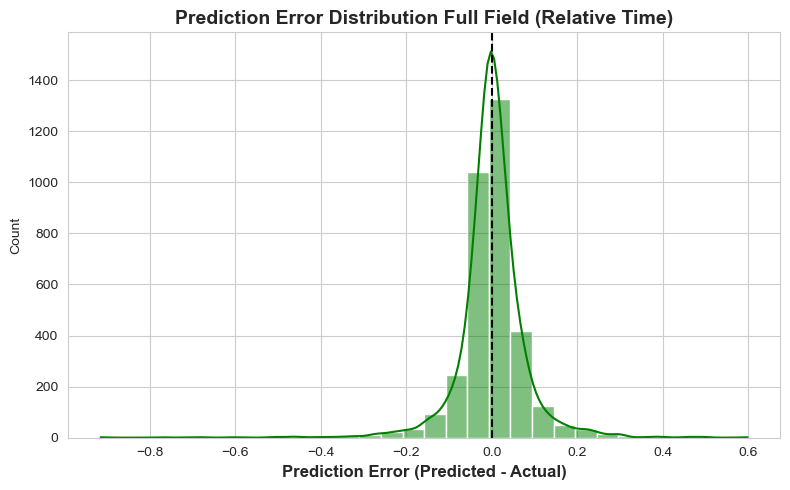

In [240]:
import os

# Ensure the 'plots' directory exists
os.makedirs("plots", exist_ok=True)

# --- 2. Error Distribution Histogram ---
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color='green')
plt.axvline(0, linestyle='--', color='black')
plt.title("Prediction Error Distribution Full Field (Relative Time)", fontsize=14, fontweight='bold')
plt.xlabel("Prediction Error (Predicted - Actual)", fontsize=12, fontweight='bold')
plt.tight_layout()

# Save to file
plt.savefig("plots/error_distribution_relative_time_full.png", dpi=300)

# Display
plt.show()

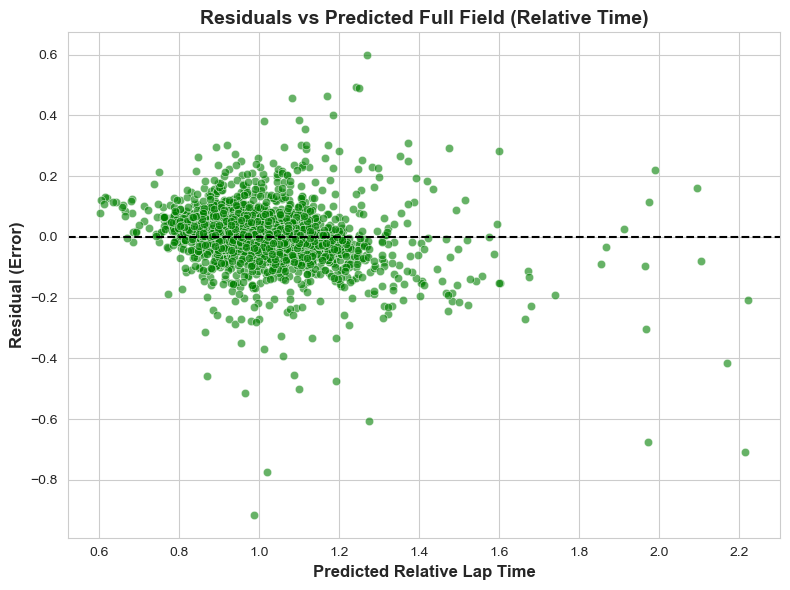

In [241]:
# --- 3. Residuals vs Predicted ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predicted, y=errors, color='green', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals vs Predicted Full Field (Relative Time)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Relative Lap Time", fontsize=12, fontweight='bold')
plt.ylabel("Residual (Error)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("plots/residuals_vs_predicted_full.png", dpi=300)
plt.show()

### check for overfitting

In [242]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model.fit(X_train, y_train)

# Evaluate on both sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE :", mean_absolute_error(y_test, y_test_pred))

Train MAE: 0.036724144061271904
Test MAE : 0.09882410732649552


model performs much better on training data than on unseen test data.

red flag, especially for Random Forests

### 🧠 Final Analysis: Historical-Based Race Performance Prediction

This project aimed to predict individual race performance in relation to demographic peers using only **past race data** for each racer. By focusing on **historical relative lap times**, we eliminated data leakage and mimicked a real-world scenario where only past results are known.

---

### ✅ Model Overview

- **Target:** `relative_time_to_peer` (lap time as a ratio of peer group average)
- **Key Feature:** `historical_relative_mean` — average relative performance in prior races
- **Model:** Random Forest Regressor

---

### 📊 Results Summary

| Group          | MAE     | RMSE    | Interpretation                          |
|----------------|---------|---------|------------------------------------------|
| All Racers     | 0.1023  | 0.0245  | Avg prediction error ~10.2% from actual  |
| Fast Outliers  | 0.1823  | 0.0427  | Avg prediction error ~18.2% from actual  |

---

### 🔍 Interpretation

- The model performs **reasonably well across the entire population**, with a mean absolute error of just over **10%**. This suggests it captures stable trends in how racers typically perform compared to their age and gender group.
- **Fast outliers**—by definition—deviate from their peers in exceptional ways. As expected, they are **harder to predict**, with nearly double the average error. This highlights the natural challenge of modeling elite, edge-case performances.
- The **low RMSE** values across both groups suggest most predictions are close to actual values, with only a few large deviations.
- There is **likely overfitting** due to the high relative performance on training vs test data.

---

### 🧪 Takeaways

- **Historical relative performance** is a strong predictor of future performance, even without complex physiological or environmental data.
- Predicting the performance of **outliers is inherently more difficult** and likely requires more granular features or richer history (e.g. course type, weather, physiological data).
- This modeling approach is robust, fair (peer-normalized), and practical for deployment in real race analysis pipelines.

---

### 🚀 Next Steps

- Use **model interpretability techniques** like SHAP to understand what contributes most to each prediction.
- Limit **tree depth and complexity** to reduce the chance of random forest memorizing training data
- Test **linear or ridge regression** to identify models less prone to overfitting